# TomoTools Demo
* TomoTools is a Hyperspy-based package designed for manipulating and reconstructing electron tomography data
* Depends on several external libraries beyond Hyperspy
    * OpenCV: spatial registration
    * TomoPy: reconstruction
    * Astra Toolbox: GPU-based reconstruction

### Installation
* Install external packages:
    * conda install -c conda-forge hyperspy
    * conda install -c conda-forge opencv
    * conda install -c astra-toolbox astra-toolbox
    * conda install -c conda-forge tomopy
    
    
* Install TomoTools via pip:
    * pip install git+https://gitlab.com/aaherzing/tomotools.git

In [1]:
%matplotlib notebook
import tomotools.api as tomotools
import matplotlib.pylab as plt

### Read data from HDF5 file
- Converts to TomoStack, a sub-class of HyperSpy's Signal2D
* In this case, the tilts angles have to be manually supplied

<IPython.core.display.Javascript object>


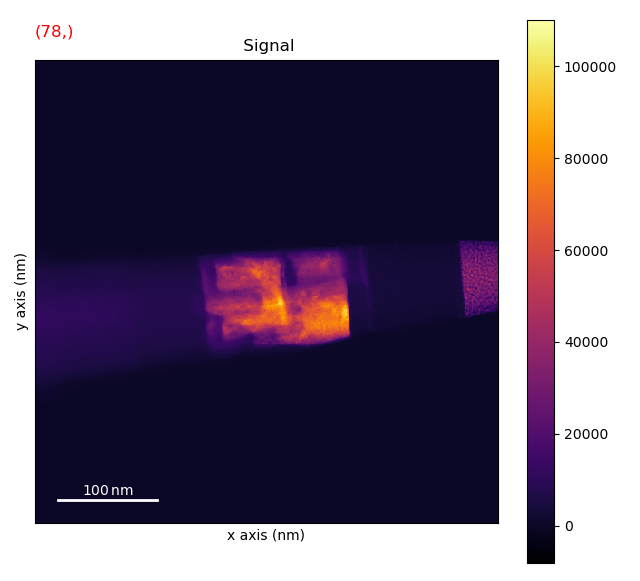

In [2]:
haadf = tomotools.load('data/TomoTools_HAADF.hdf5')
haadf.plot(navigator='slider',cmap='inferno',vmin=-8000,vmax=110000)

### Spatially register the image stack 
- Using enhanced correlation coefficient algorithm as implemented in OpenCV

100%|██████████| 39/39 [00:01<00:00, 30.99it/s]


<IPython.core.display.Javascript object>


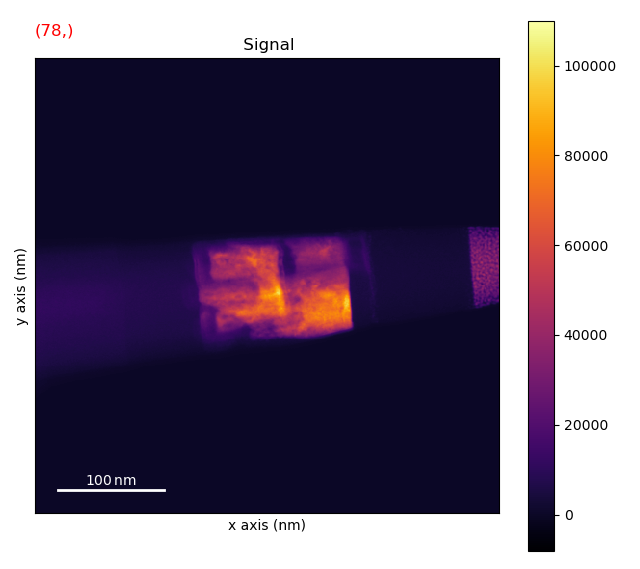

In [3]:
reg = haadf.stack_register('ECC', crop=True, show_progressbar=True)
reg.plot(navigator='slider',cmap='inferno',vmin=-8000,vmax=110000)

### Align the tilt axis and lateral shift
- Minimizes reconstruction artifacts
- Based on tracking the center of mass (CoM) of the needle
- User must specify three locations in stack from which to perform the fitting
- It is best to choose locations that are in a single phase slice of the data

<IPython.core.display.Javascript object>


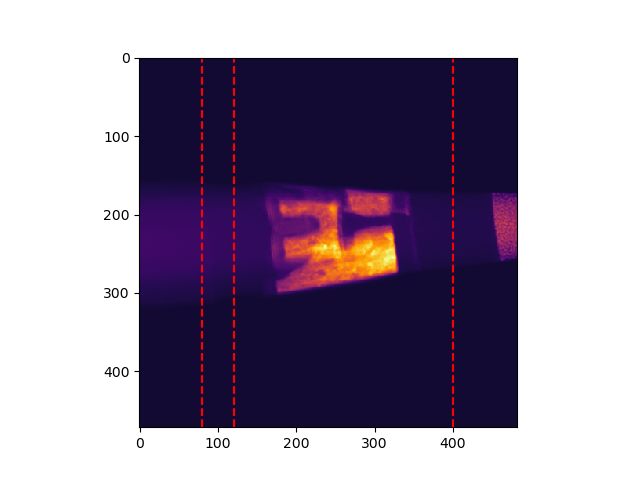

In [4]:
fig,ax = plt.subplots(1)
ax.imshow(reg.data[35,:,:], cmap='inferno', vmin=-8000,vmax=80000)
ax.axvline(80,color='red',linestyle='--')
ax.axvline(120,color='red',linestyle='--')
ax.axvline(400,color='red',linestyle='--')


Correcting tilt axis....
Iteration #1
Calculated tilt correction is: -4.465749020817765
Calculated shift value is: -22.895000107289377
Iteration #2
Calculated tilt correction is: -0.18698905970705576
Calculated shift value is: 16.789522421525362
Iteration #3
Calculated tilt correction is: -0.056722010886665473
Calculated shift value is: 0.7149143147397012

Tilt axis alignment complete


<IPython.core.display.Javascript object>


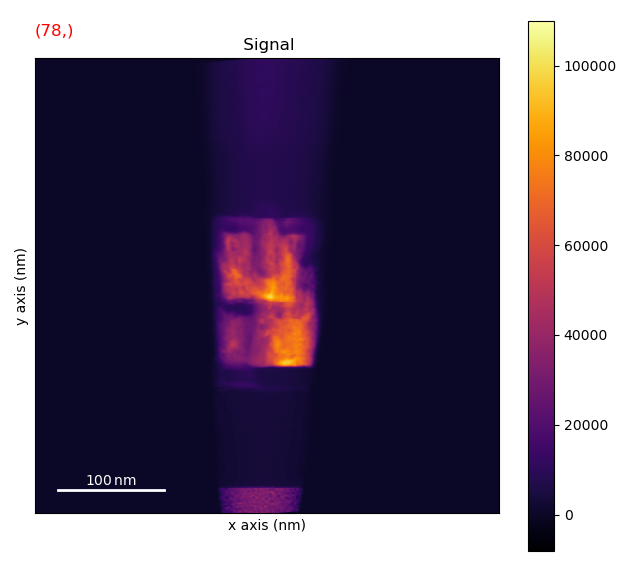

In [5]:
ali = reg.tilt_align('CoM',locs=[80,120,400])
ali.plot(navigator='slider',cmap='inferno',vmin=-8000,vmax=110000)

## Test aligment and reconstruction parameters
* Reconstructs three slices only to provide quick feedback about alignment and reconstruction parameters
* Can also be used for manually performing coarse alignment of X-shift and tilt axis rotation

Reconstructing 8 slice groups with 3 master threads...
Reconstruction complete


<IPython.core.display.Javascript object>


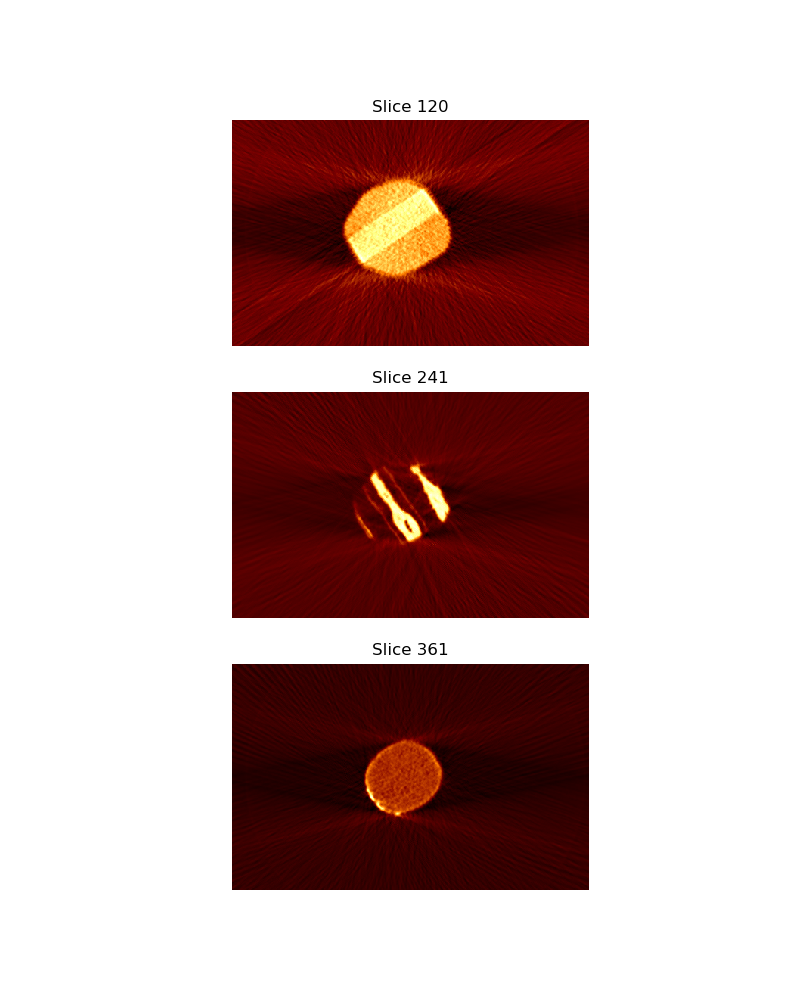

In [6]:
ali.test_align(thickness = 300)

## Reconstruct using weighted-backprojection
* Full dataset reconstructed
* Data can be vizualized in the X-Z orientation
* Visualization in other orientations can be achieved using the `swap_axes` Hyperspy method


### Reconstruct subset of full stack for speed

In [7]:
recWBP = ali.isig[:,150:350].reconstruct(method='FBP',thickness=300)

Reconstructing 8 slice groups with 8 master threads...
Reconstruction complete


<IPython.core.display.Javascript object>


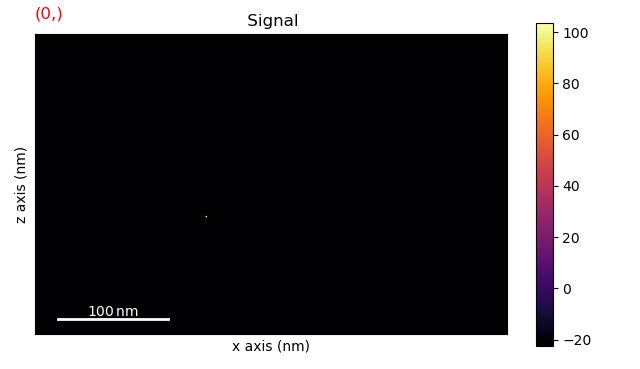

In [8]:
recWBP.plot(navigator='slider',cmap='inferno',vmin=100)

<IPython.core.display.Javascript object>


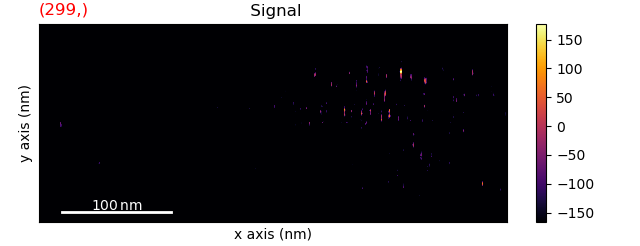

In [9]:
recWBP.swap_axes(0,2).plot(navigator='slider',cmap='inferno',vmin=100)

### Reconstruct full stack

In [10]:
recWBP_full = ali.reconstruct(method='FBP',thickness=300)

Reconstructing 8 slice groups with 8 master threads...
Reconstruction complete


<IPython.core.display.Javascript object>


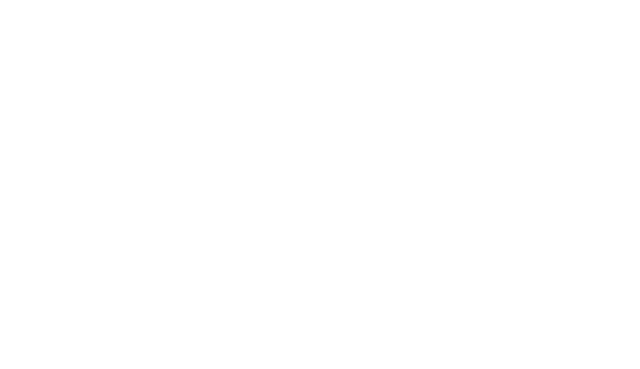

In [11]:
recWBP_full.plot(navigator='slider',cmap='inferno',vmin=100)

<IPython.core.display.Javascript object>


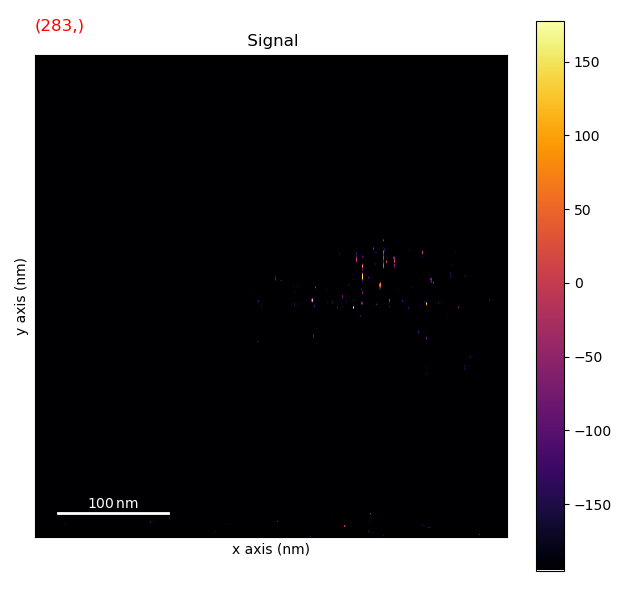

In [12]:
recWBP_full.swap_axes(0,2).plot(navigator='slider',cmap='inferno',vmin=100)

## Reconstruct the data using simulataneous iterative reconstruction technique (SIRT). 
- In this case, only ten slices from the middle of the stack are reconstructed to speed things up.
- 150 iterations
- Apply a positivity constraint

In [13]:
recSIRT150 = ali.isig[:,250:260].reconstruct(method='SIRT',thickness=300,iterations=150,constrain=True)

Reconstructing 8 slice groups with 8 master threads...
Reconstruction complete


<IPython.core.display.Javascript object>


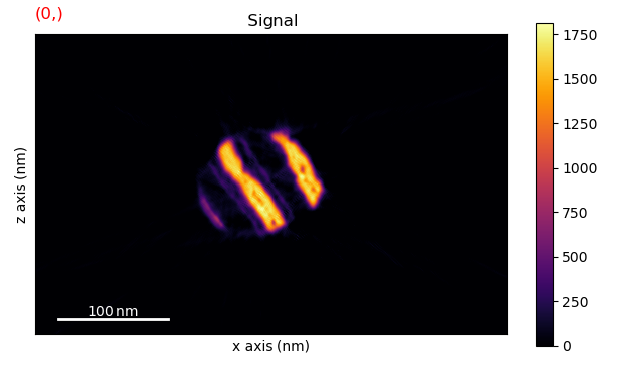

In [14]:
recSIRT150.plot(navigator='slider', cmap='inferno')

## Reconstruct the entire dataset SIRT
- 150 iterations
- Apply a positivity constraint

In [15]:
recSIRT150Full = ali.reconstruct(method='SIRT',thickness=300,iterations=150,constrain=True)

Reconstructing 8 slice groups with 8 master threads...
Reconstruction complete


## Save the aligned dataset and the reconstruction. 
- Data saved using HyperSpy's I/O functionality
- Compressed HDF5 format
- All metadata stored with data

In [16]:
ali.save('data/1_HAADF_Aligned.hdf5')
recWBP.save('data/1_HAADF_WBP.hdf5')
recSIRT150.save('data/1_HAADF_SIRT150_10Slices.hdf5')
recSIRT150Full.save('data/1_HAADF_SIRT150_Full.hdf5')

## Visualizing results with `ipyvolume`